**Evaluation of different machine learning algorithms for the generation of trading signals**

The purpose of this code is to evaluate different machine learning algorithm to generate signals from financial technical indicators. 
In order to take into account a large set of possibilities, we will try with a large set of technical indicators and a large list of machine learning algorithm. 
We can then refine usine variable selection as well as picking the best algorithms. 
The target variable here is a positive / negative trading signal for a long position (hope for positive returns). Target can be either one time period postive returns or a series of positive returns of a defined lenght. 
The algorithm that we will test will then be classification algorithms. 

The evaluation will be done using KFold Cross Validation. 
Once the best models have been selected one can go on for hyperparameter calibration as well as variable selection. 

In [ ]:
!pip install yahoo_fin

In [ ]:
!pip install stockstats

In [43]:
from yahoo_fin.stock_info import get_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [45]:
from stockstats import StockDataFrame

In [46]:
df = StockDataFrame.retype(get_data(ticker = "XOM", start_date='01/01/2001'))

In [47]:
# adding all the technical indicators we need:
# change is the 1 day return on the close price
# log ret is the 1 day log return 

df[["change", "rate", "close_-1_d", "log-ret", "high_5_sma", "close_10_sma", "close_10_ema", "close_30_sma","close_20_ema", "rsi_6", "rsi_14", "atr_14", "macd", "macds", "adx"]]

,change,rate,close_-1_d,log-ret,high_5_sma,close_10_sma,close_10_ema,close_30_sma,close_20_ema,rsi_6,rsi_14,atr_14,macd,macds,adx
2001-01-02,0.000000,NaN,0.000000,0.000000,44.687500,44.562500,44.562500,44.562500,44.562500,NaN,NaN,1.437500,0.000000,0.000000,NaN
2001-01-03,-4.347826,-4.347826,-1.937500,-0.044452,44.781250,43.593750,43.496875,43.593750,43.545313,0.000000,0.000000,1.858796,-0.043470,-0.024150,100.000000
2001-01-04,-2.785924,-2.785924,-1.187500,-0.028255,44.145833,42.875000,42.669020,42.875000,42.771336,0.000000,0.000000,1.875800,-0.092213,-0.052045,100.000000
2001-01-05,0.452489,0.452489,0.187500,0.004515,43.742188,42.562500,42.325062,42.562500,42.440407,7.432897,6.332795,1.666749,-0.105353,-0.070103,100.000000
2001-01-08,-0.450450,-0.450450,-0.187500,-0.004515,43.412500,42.337500,42.070267,42.337500,42.197812,6.824213,5.928477,1.448061,-0.117736,-0.084273,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-14,-0.508990,-0.508990,-0.579994,-0.005103,113.556000,111.929000,111.473867,105.892667,108.807652,61.607753,63.995504,2.975842,3.692986,3.836884,26.025802
2022-11-15,0.670366,0.670366,0.759995,0.006681,113.529999,112.150999,111.956800,106.521333,109.314542,64.533381,65.167613,2.881853,3.670935,3.803694,24.721749
2022-11-16,-1.068951,-1.068951,-1.219994,-0.010747,113.725999,112.481000,112.130109,106.981000,109.656967,56.272934,61.695479,2.847435,3.514504,3.745856,20.093934
2022-11-17,0.132844,0.132844,0.149994,0.001328,114.225999,112.677000,112.299180,107.347667,109.981065,57.083413,61.963805,2.819046,3.363857,3.669456,15.606946


In [ ]:
df['10_ema_signal'] = np.where(df['close']> df['close_10_ema'], 1, -1) # this would be a bullish signal: when the price is above short term average
df["short_long_ema_signal"] =  np.where(df['close_10_ema']> df['close_20_ema'], 1, -1) # this is a short long ema signal: a bit equivalent to macd without taking into account the level of the gap
df['macd_signal_macd'] =  np.where(df['macds'] > df['macd'], 1, -1) # seems to go all in the bullish direction, cause here signal and macd can be negative
# creating the target variables:
df['target'] = np.where(df["change"] > 0, 1, 0) # we only check for positive returns 
# we could check for a series of positive returns: would be more interesting: a good leg


In [15]:
df = df.dropna(how='any')

Should we keep the close price or some price reference in the X data table or only keep the technical indicators ?

In [19]:
# define our sample data and target variable tensor

X = df[["10_ema_signal", "macd_signal_macd", "rsi_6", "atr_14", "short_long_ema_signal", "adx"]] # should we convert to np? 
y = df['target']


In [26]:
X.isna()

,10_ema_signal,macd_signal_macd,rsi_6,atr_14,short_long_ema_signal,adx
2001-01-03,False,False,False,False,False,False
2001-01-04,False,False,False,False,False,False
2001-01-05,False,False,False,False,False,False
2001-01-08,False,False,False,False,False,False
2001-01-09,False,False,False,False,False,False
...,...,...,...,...,...,...
2022-11-14,False,False,False,False,False,False
2022-11-15,False,False,False,False,False,False
2022-11-16,False,False,False,False,False,False
2022-11-17,False,False,False,False,False,False


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [23]:

# import the ML library that we are going to use:
# logistic regression
# decision tree
# random forest
# Adaboost

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor # regressor or classifier ??
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


In [35]:
# let's search what the classification models give:

# initialization of all models, then apply cv to them on the data X and y
seed = 8
models = [
              ('LogisticRegression', LogisticRegression(random_state=seed)),
              ('KNN', KNeighborsClassifier()),
              ('DecisionTreeClassifier', DecisionTreeClassifier()),
              ('Naive Bayes', GaussianNB()),
              ('RandomForest', RandomForestClassifier()),
              ('AdaBoost', AdaBoostClassifier(DecisionTreeClassifier(random_state = seed), random_state = seed,
                                              learning_rate = 0.1)),
              ('SVM', svm.SVC(random_state=seed)),
              ('GradientBoosting', GradientBoostingClassifier(random_state=seed))
]


def trade_model_evaluation(X, y, models):
  results = []
  names = []
  scoring = 'accuracy'  # could think of other metrics like AUC/ROC
  for name, model in models:
    print(name)
    kfold = KFold(n_splits = 10, shuffle=True, random_state=seed)
    cv_result = cross_val_score(model, X, y, cv=kfold, scoring = scoring)
    results.append(cv_result)
    names.append(name)
    
    msg = "{} : mean {} and std {}".format(name, cv_result.mean(), cv_result.std())
    print(msg) 
  return results, names

In [36]:
results, names = trade_model_evaluation(X= X_train, y = y_train, models = models)

LogisticRegression
LogisticRegression : mean 0.7372928262213976 and std 0.018666827362098667
KNN
KNN : mean 0.7243444650587507 and std 0.01375211874907326
DecisionTreeClassifier
DecisionTreeClassifier : mean 0.673248299319728 and std 0.030508920774727825
Naive Bayes
Naive Bayes : mean 0.6925577200577202 and std 0.01895036590909423
RandomForest
RandomForest : mean 0.7359333127190271 and std 0.022663034317348545
AdaBoost
AdaBoost : mean 0.6748397237682953 and std 0.030171797654805068
SVM
SVM : mean 0.7161719233147805 and std 0.02285316412914255
GradientBoosting
GradientBoosting : mean 0.75818130282416 and std 0.017967411280720637


In [37]:
df_cv_scores = pd.DataFrame(np.stack(results, axis= 1), columns = names)

In [38]:
import plotly.express as px

In [39]:
fig = px.box(df_cv_scores)
fig.show()

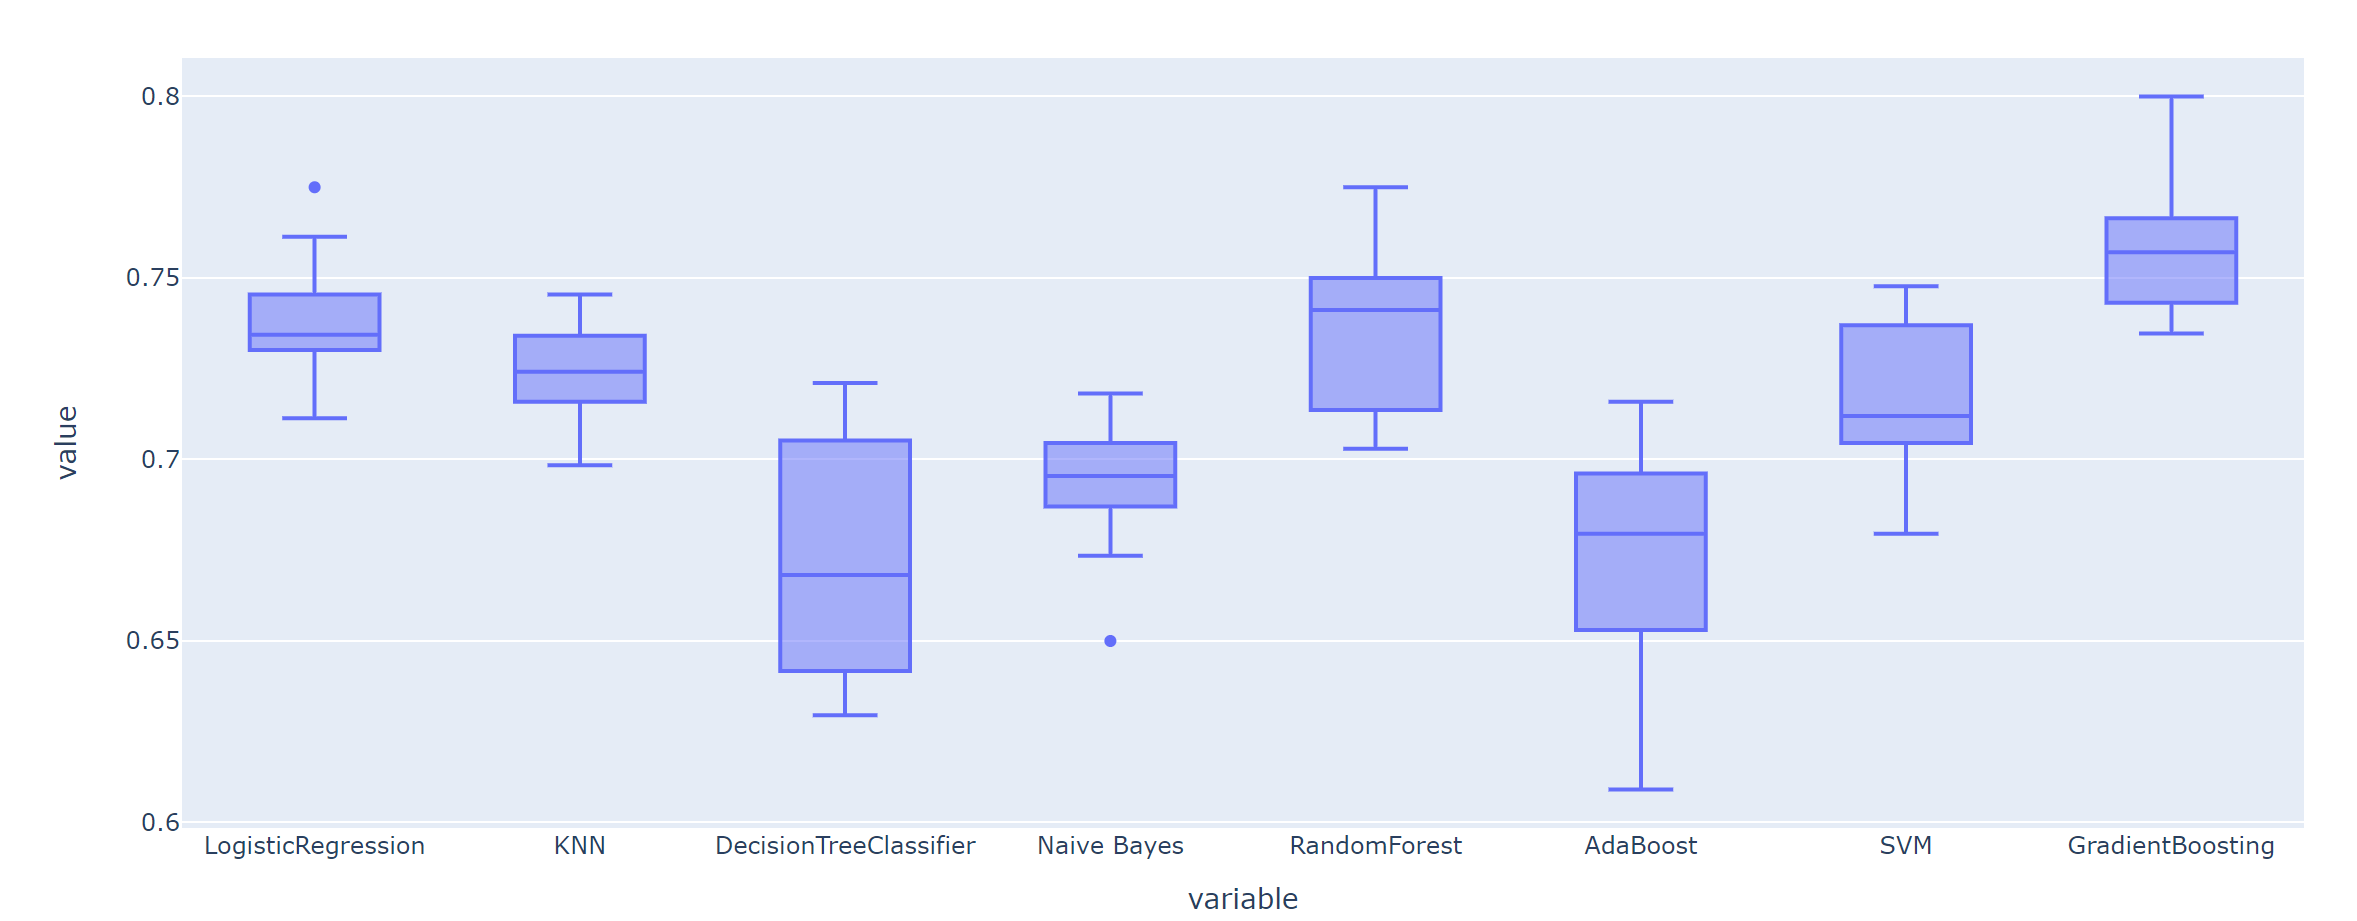

In [ ]:
# we are going to do the grid search only for the 2 best algo: Gradient Boosting an Random Forest

selected_model = [('GradientBoosting', GradientBoostingClassifier(random_state=seed)), 
                  ('RandomForest', RandomForestClassifier())]


GB_parameters = {'learning_rate': np.linspace(0.005, 0.05, 0.1), 
                  'subsample'    : [0.9, 0.5, 0.2],
                  'n_estimators' : np.linspace(10, 1000, 100),
                  'max_depth'    : [4,6,8]
                 'min_samples_split': np.linspace(),
                 'min_samples_leaf': np.linspace(),
                 }
RF_parameters = {'n_estimators': np.linspace(10, 1000, 100),
                 'max_depth': [4,6,8],
                 'min_samples_split': np.linspace(3, 10, 7) ,
                 'max_features':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]    
}

grid_search = GridSearchCV(estimator = GradientBoostingClassifier(random_state=seed), param_grid = GB_parameters, 
  cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)


In [42]:
gb_best_params = grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.2}

In [ ]:
grid_search_rf = GridSearchCV(estimator = GradientBoostingClassifier(random_state=seed), param_grid = RF_parameters, 
  cv = 3, n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train, y_train)


In [ ]:
# Replace the target variable not only by one positive return day but a series of two or a threshold of cumulative returns